# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
!pip install optuna factor-analyzer -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 8.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings

from google.colab import drive
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo, FactorAnalyzer
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

drive.mount('/content/drive')
warnings.filterwarnings('ignore')

Mounted at /content/drive


# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Machine Learning /Dataset/Airline Passenger.csv")

In [4]:
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,5,4,3,4,4,5,5,25,18.0
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,1,5,3,1,4,1,1,6.0
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,5,4,3,4,4,4,5,0,0.0
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,2,5,3,1,4,2,11,9.0
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,5,3,3,4,4,3,3,3,0,0.0


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     1039

In [6]:
df.drop('id', axis=1,inplace=True)

In [7]:
df.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


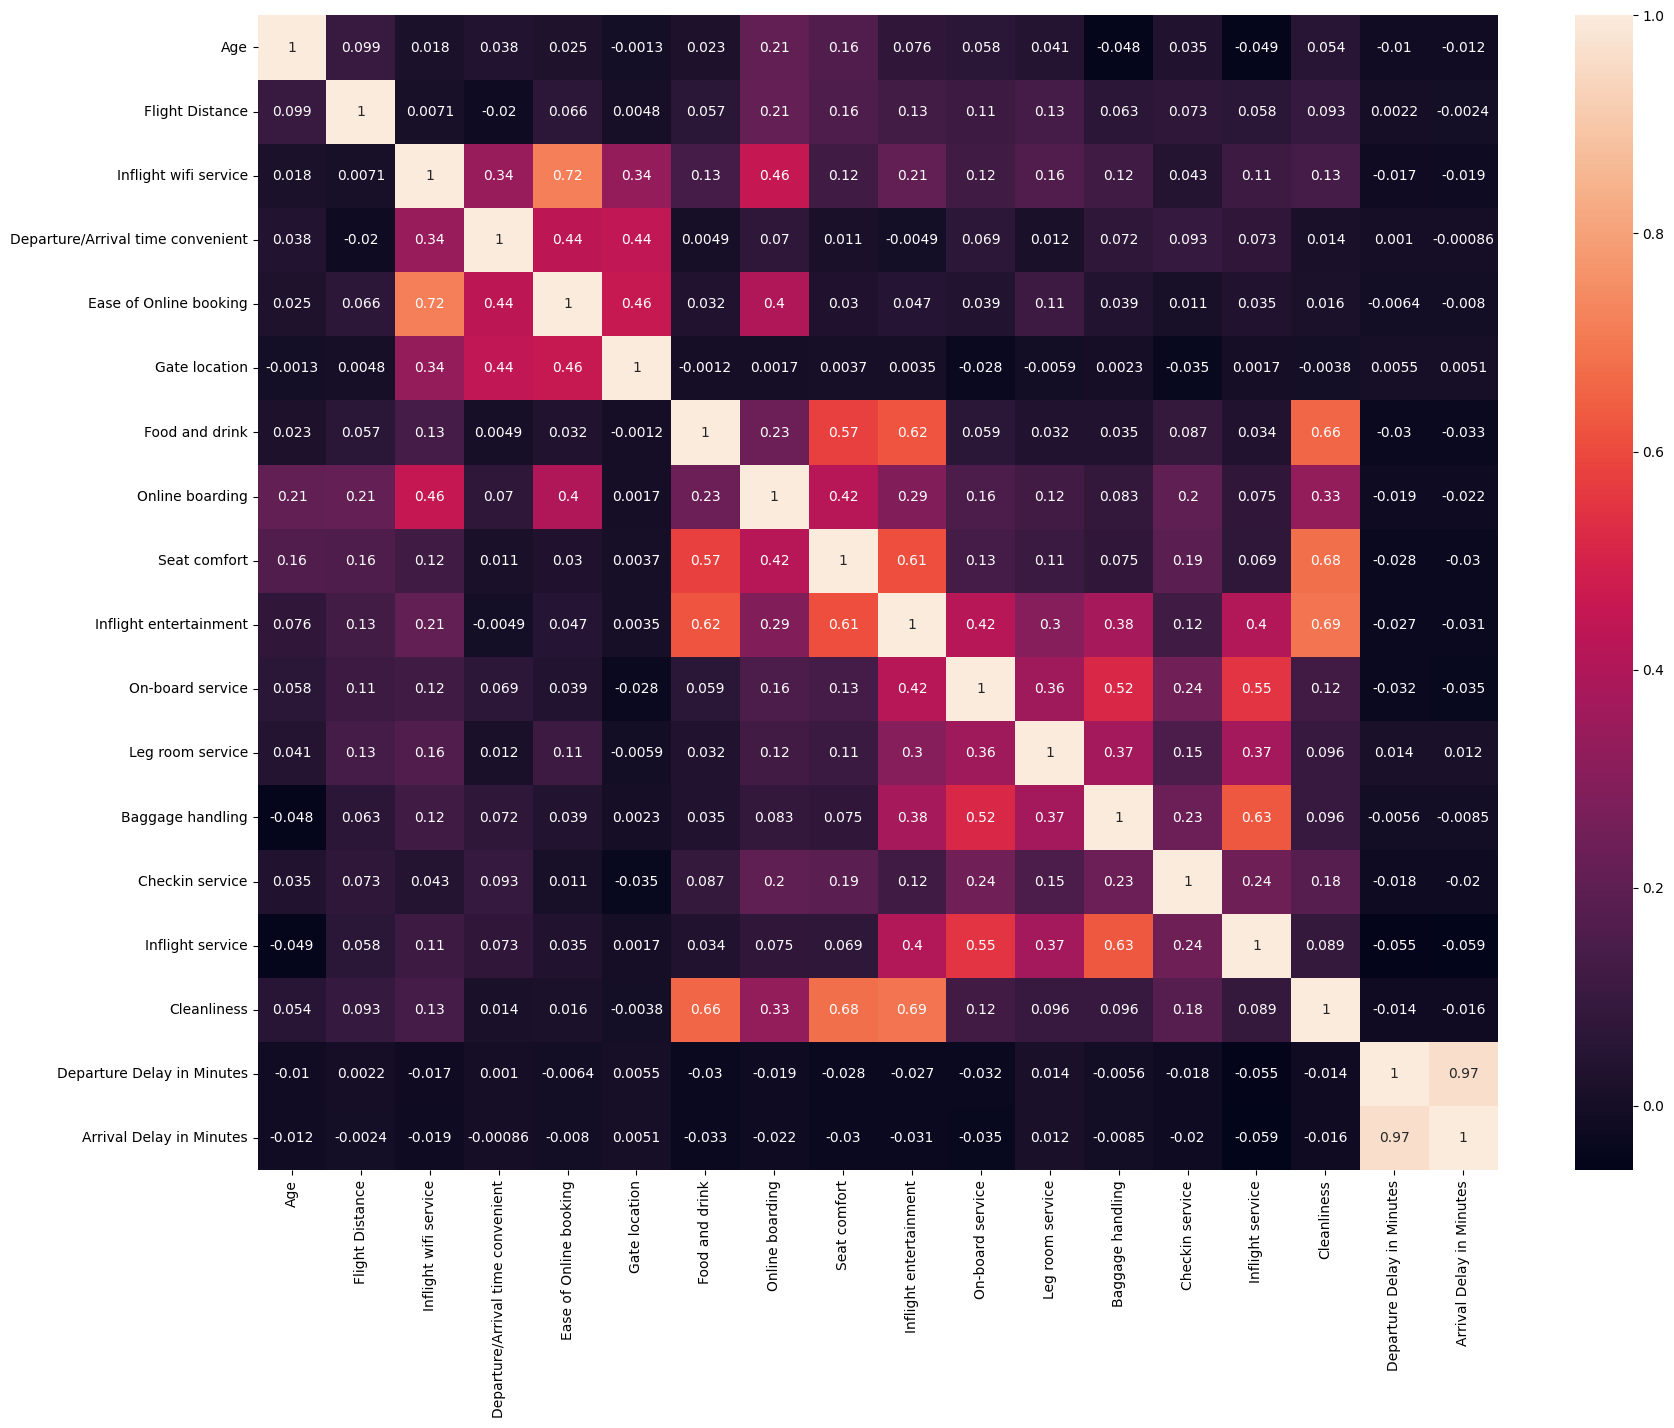

In [8]:
plt.figure(figsize=(20,15))
sns.heatmap(df.select_dtypes(exclude='object').corr(), annot=True)
plt.show()

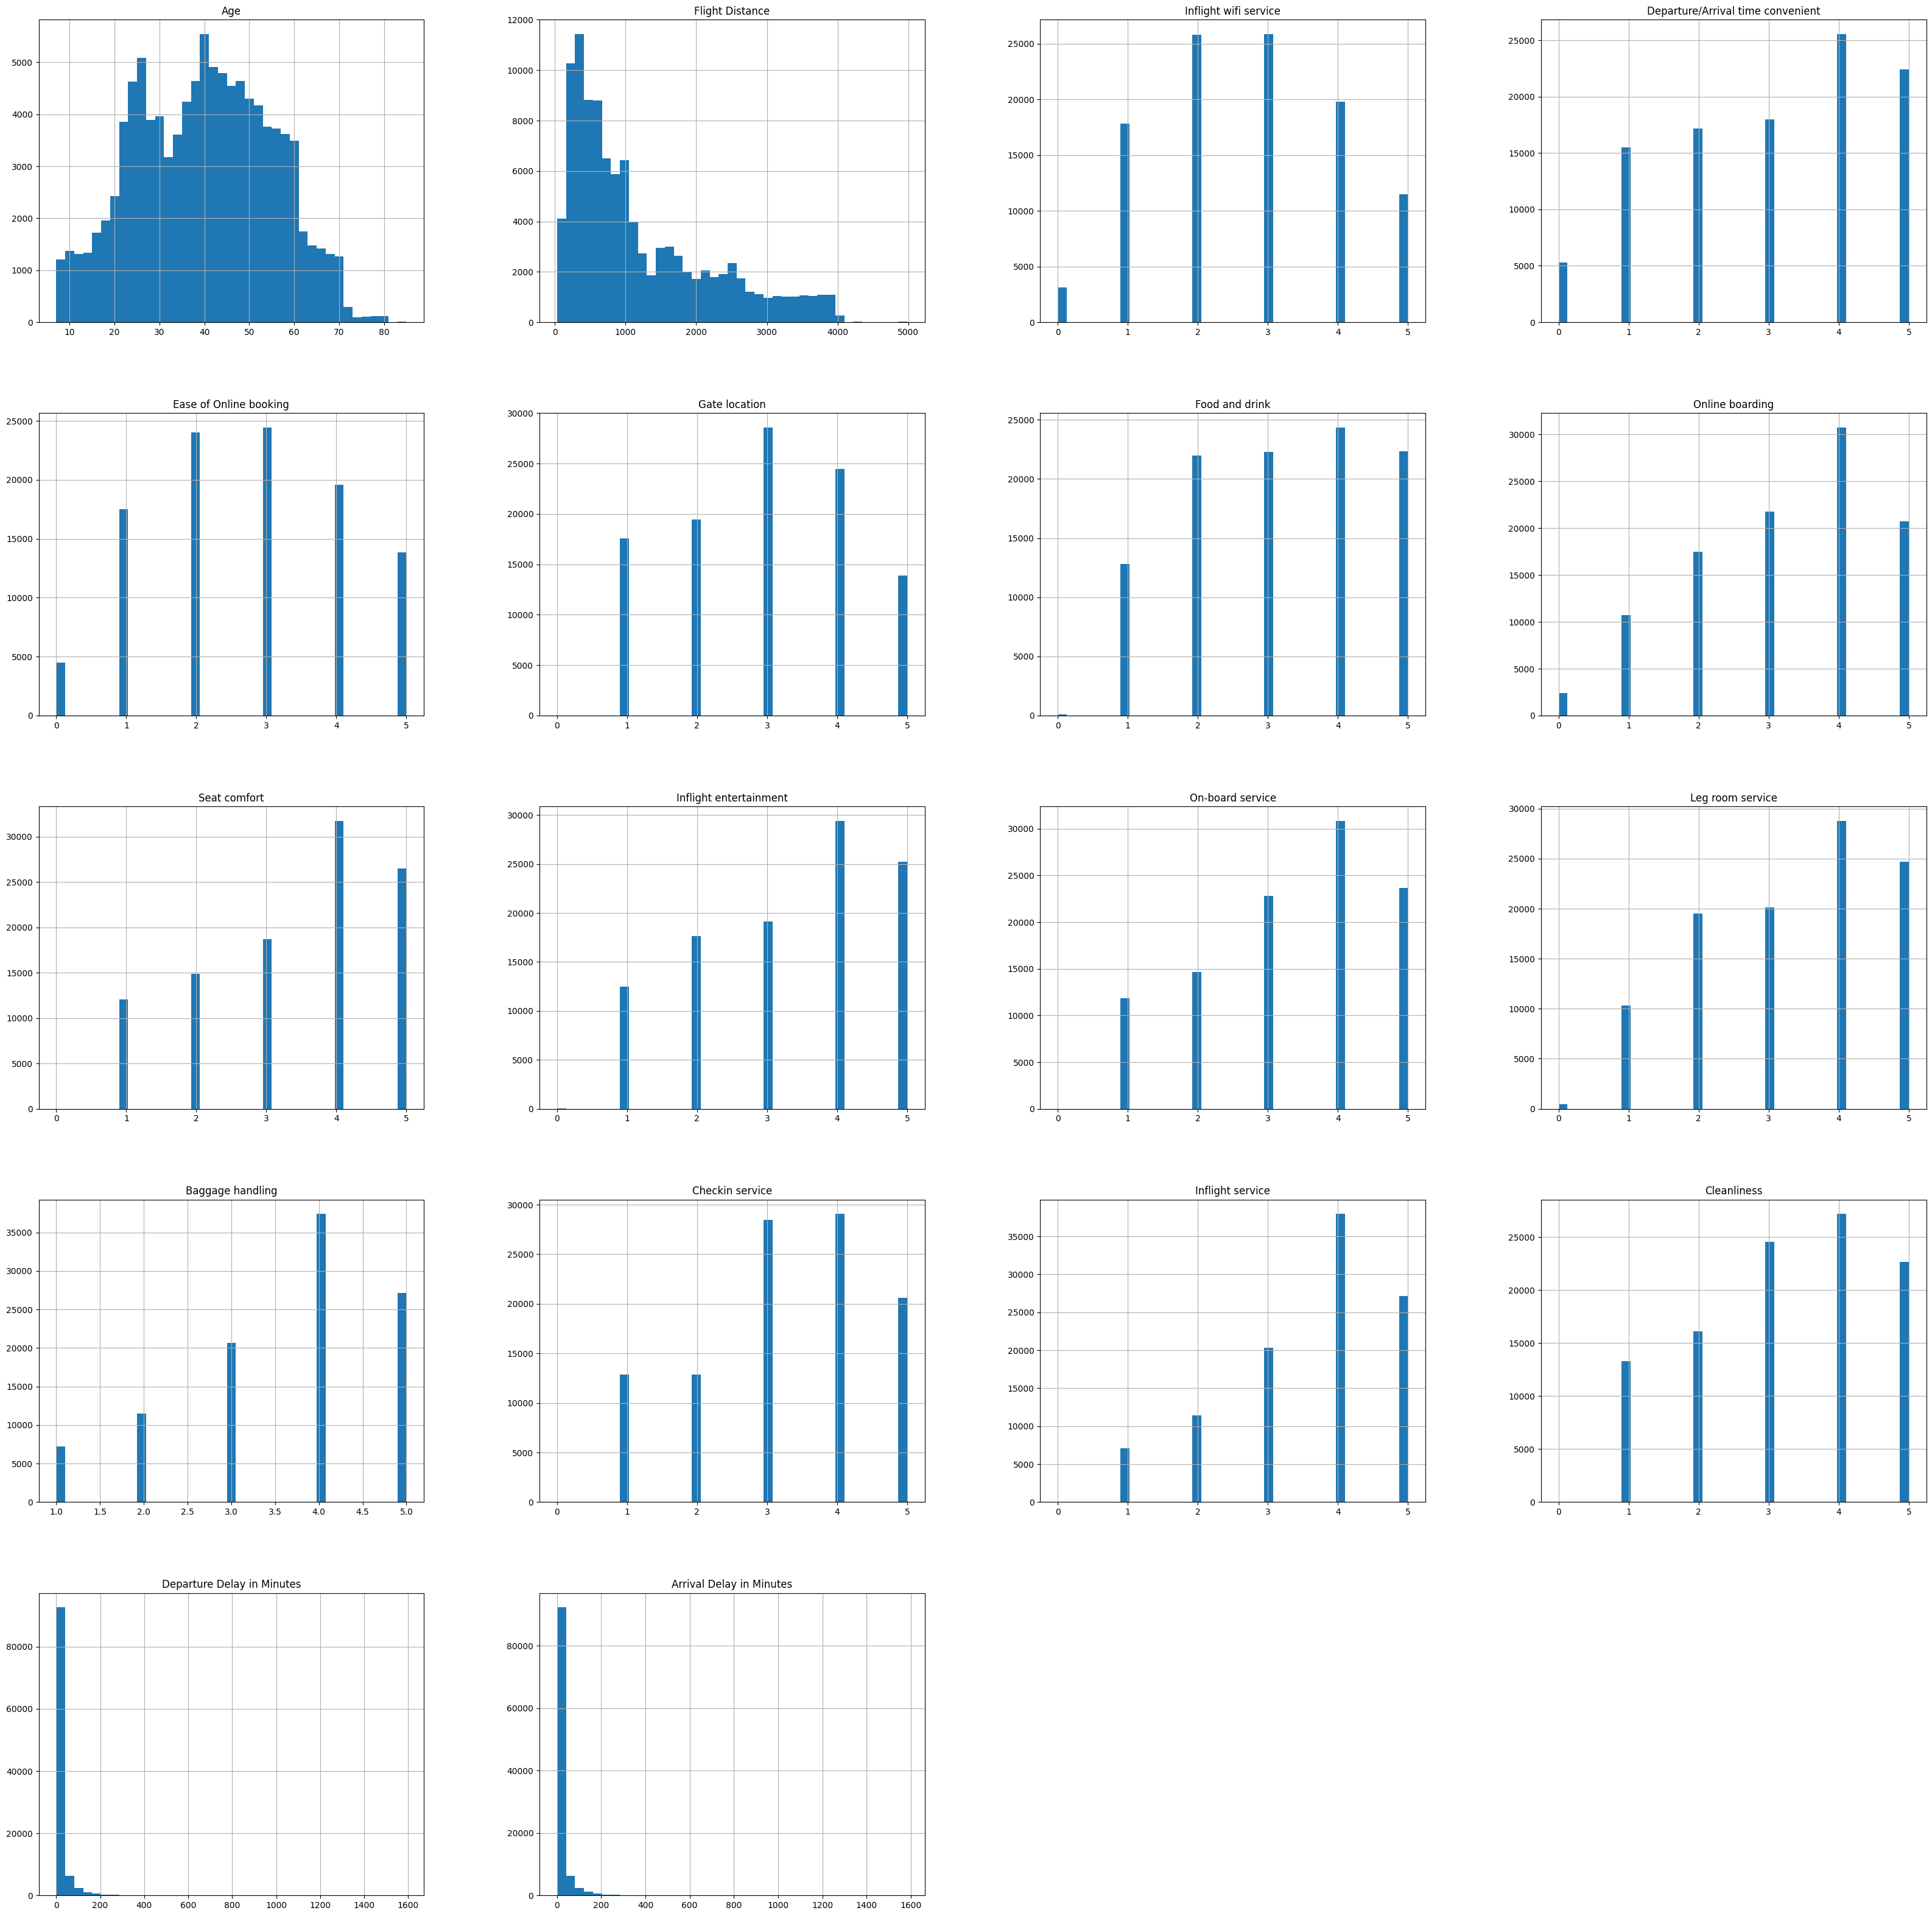

In [9]:
bins = int(1 + 3.3 * np.log(df.shape[0]))
df.hist(figsize=(40, 40), bins=bins)
plt.show()

Terdapat beberapa data yang memiliki distribusi belum mendekati normal atau mengalami skewed. Maka perlu untuk melakukan transformation sederhana seperti log, sqrt, yeo/boxcox. Kemudian scaling dengan standarization.

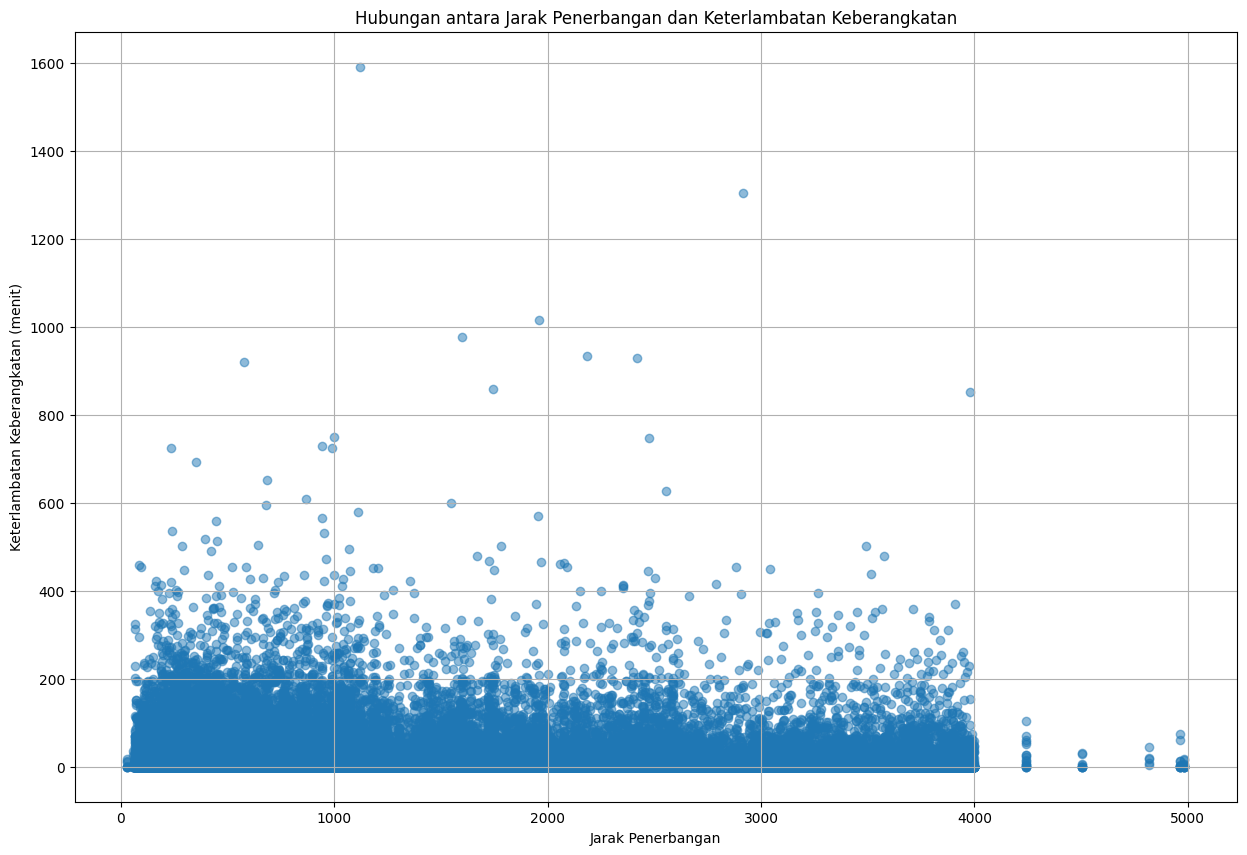

In [10]:
plt.figure(figsize=(15 , 10))
plt.scatter(df['Flight Distance'], df['Departure Delay in Minutes'], alpha=0.5)
plt.title('Hubungan antara Jarak Penerbangan dan Keterlambatan Keberangkatan')
plt.xlabel('Jarak Penerbangan')
plt.ylabel('Keterlambatan Keberangkatan (menit)')
plt.grid(True)
plt.show()

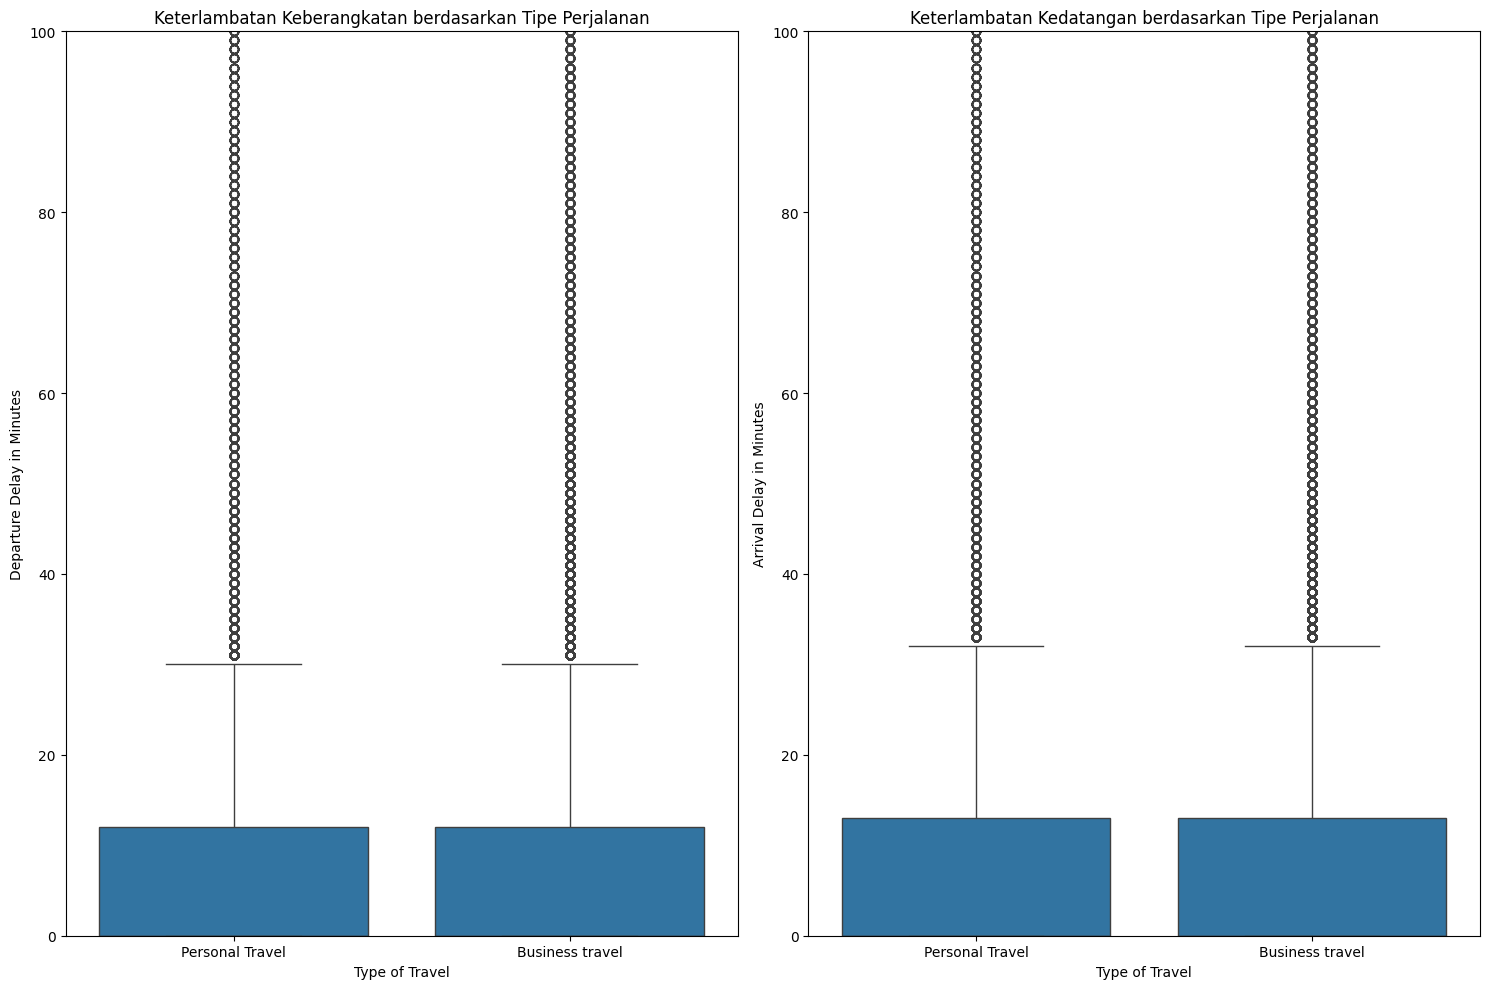

In [11]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
sns.boxplot(x='Type of Travel', y='Departure Delay in Minutes', data=df)
plt.title('Keterlambatan Keberangkatan berdasarkan Tipe Perjalanan')
plt.ylim(0, 100)  # Batasi untuk visibilitas yang lebih baik

plt.subplot(1, 2, 2)
sns.boxplot(x='Type of Travel', y='Arrival Delay in Minutes', data=df)
plt.title('Keterlambatan Kedatangan berdasarkan Tipe Perjalanan')
plt.ylim(0, 100)  # Batasi untuk visibilitas yang lebih baik

plt.tight_layout()
plt.show()

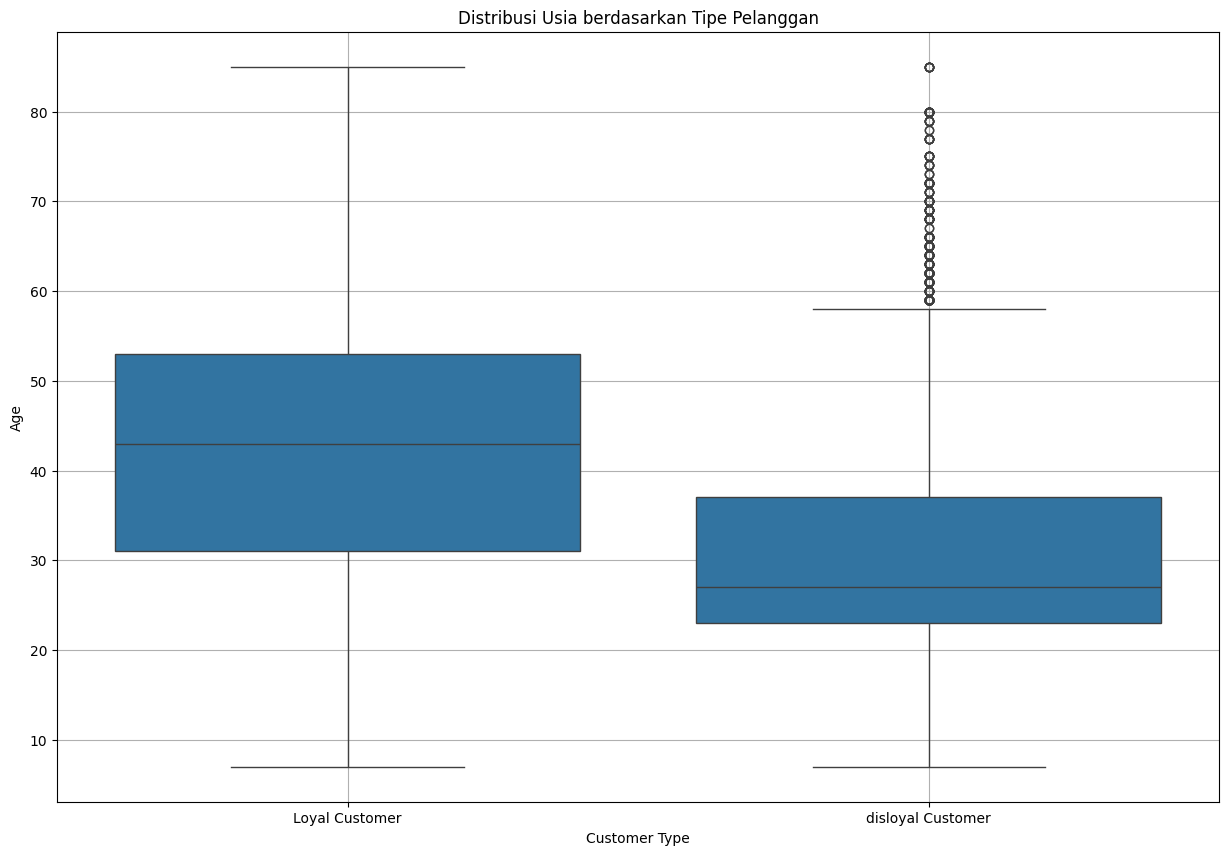

In [12]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='Customer Type', y='Age', data=df)
plt.title('Distribusi Usia berdasarkan Tipe Pelanggan')
plt.grid(True)
plt.show()

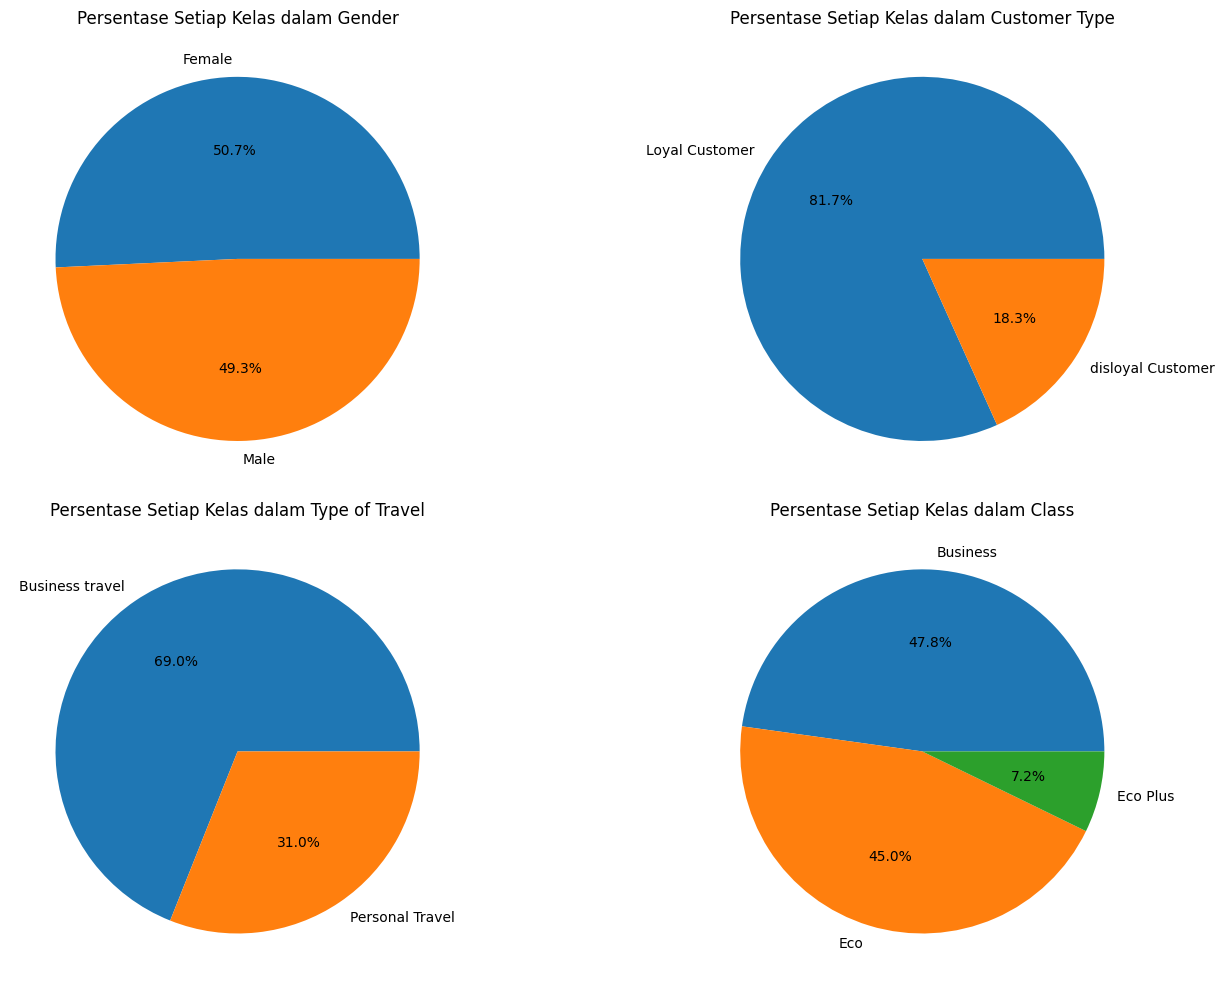

In [13]:
data_object_columns = df.select_dtypes(include='object').columns

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for index, column in enumerate(data_object_columns):
    row = index // 2
    col = index % 2
    df[column].value_counts().plot(kind='pie',
                                   ax=ax[row, col],
                                   autopct='%1.1f%%',
                                   ylabel='')

    ax[row, col].set_title(f'Persentase Setiap Kelas dalam {column}')

plt.tight_layout()
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

In [14]:
data = df.copy(deep=True)
data.drop_duplicates(inplace=True)

# **Konversi data Kategorikal ke Numerik**

In [15]:
le = LabelEncoder()

data['Gender'] = le.fit_transform(data['Gender'])
data['Customer Type'] = data['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
data['Type of Travel'] = data['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0})
data['Class'] = data['Class'].map({'Business': 2, 'Eco Plus': 1, 'Eco': 0})

# **Handling Missing Value**

## **Fill Missing Value dengan Iterative Imputer**

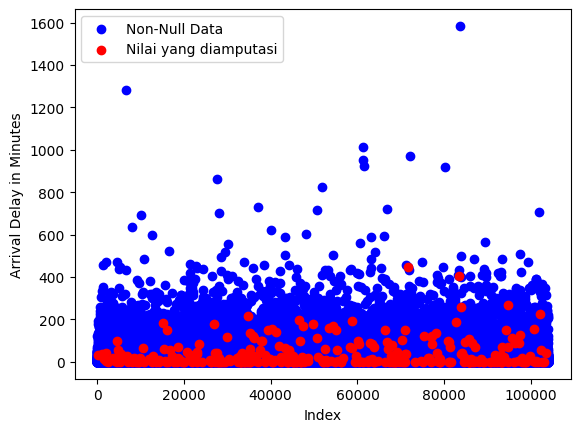

In [16]:
missing_mask = data['Arrival Delay in Minutes'].isna()

iterative_imputer = IterativeImputer(random_state=42)
data_iterative_imputed = iterative_imputer.fit_transform(data)
data_iterative_imputed = pd.DataFrame(data_iterative_imputed, columns=data.columns)

data_final_it = data_iterative_imputed.reset_index(drop=True)

plt.scatter(data_final_it.index, data_final_it['Arrival Delay in Minutes'], label='Non-Null Data', color='blue')

plt.scatter(data_final_it.loc[missing_mask, :].index,
            data_final_it.loc[missing_mask, 'Arrival Delay in Minutes'],
            color='red', label='Nilai yang diamputasi')


plt.xlabel('Index')
plt.ylabel('Arrival Delay in Minutes')
plt.legend()
plt.show()

## **Fill Missing Value dengan KNN Imputer**

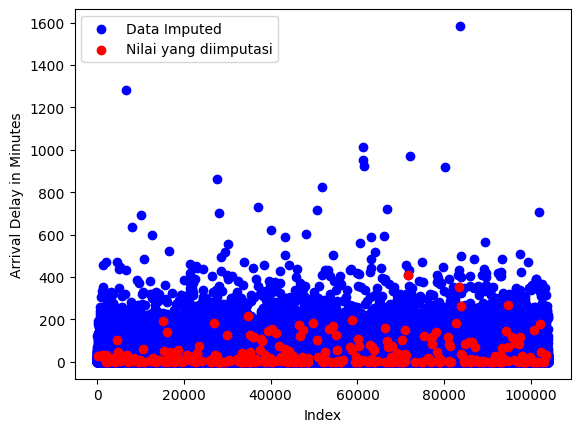

In [17]:
knn_imputer = KNNImputer(n_neighbors=7)
data_knn_imputed = knn_imputer.fit_transform(data)
data_knn_imputed = pd.DataFrame(data_knn_imputed, columns=data.columns)

data_final_knn = data_knn_imputed.reset_index(drop=True)

plt.scatter(data_final_knn.index, data_final_knn['Arrival Delay in Minutes'],
            label='Data Imputed', color='blue')

plt.scatter(data_final_knn.loc[missing_mask, :].index,
            data_final_knn.loc[missing_mask, 'Arrival Delay in Minutes'],
            color='red', label='Nilai yang diimputasi')

plt.xlabel('Index')
plt.ylabel('Arrival Delay in Minutes')
plt.legend()
plt.show()


# **Handling Outliers**

## **Clip Data**
Fitur-fitur yang diproses tidak mungkin memiliki nilai min. Maka dari itu saya melakukan clip agar nilai minimum sama dengan 0

In [18]:
con_columns = ["Departure Delay in Minutes", "Arrival Delay in Minutes", "Age", "Flight Distance"]

for column in con_columns:
    data_final_it[column] = data_final_it[column].clip(lower=0)

## **Visualisasi Outliers Dengan IQR**

In [19]:
def calculate_iqr_bounds(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = 0
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

### **Data Sebelum Transformasi**

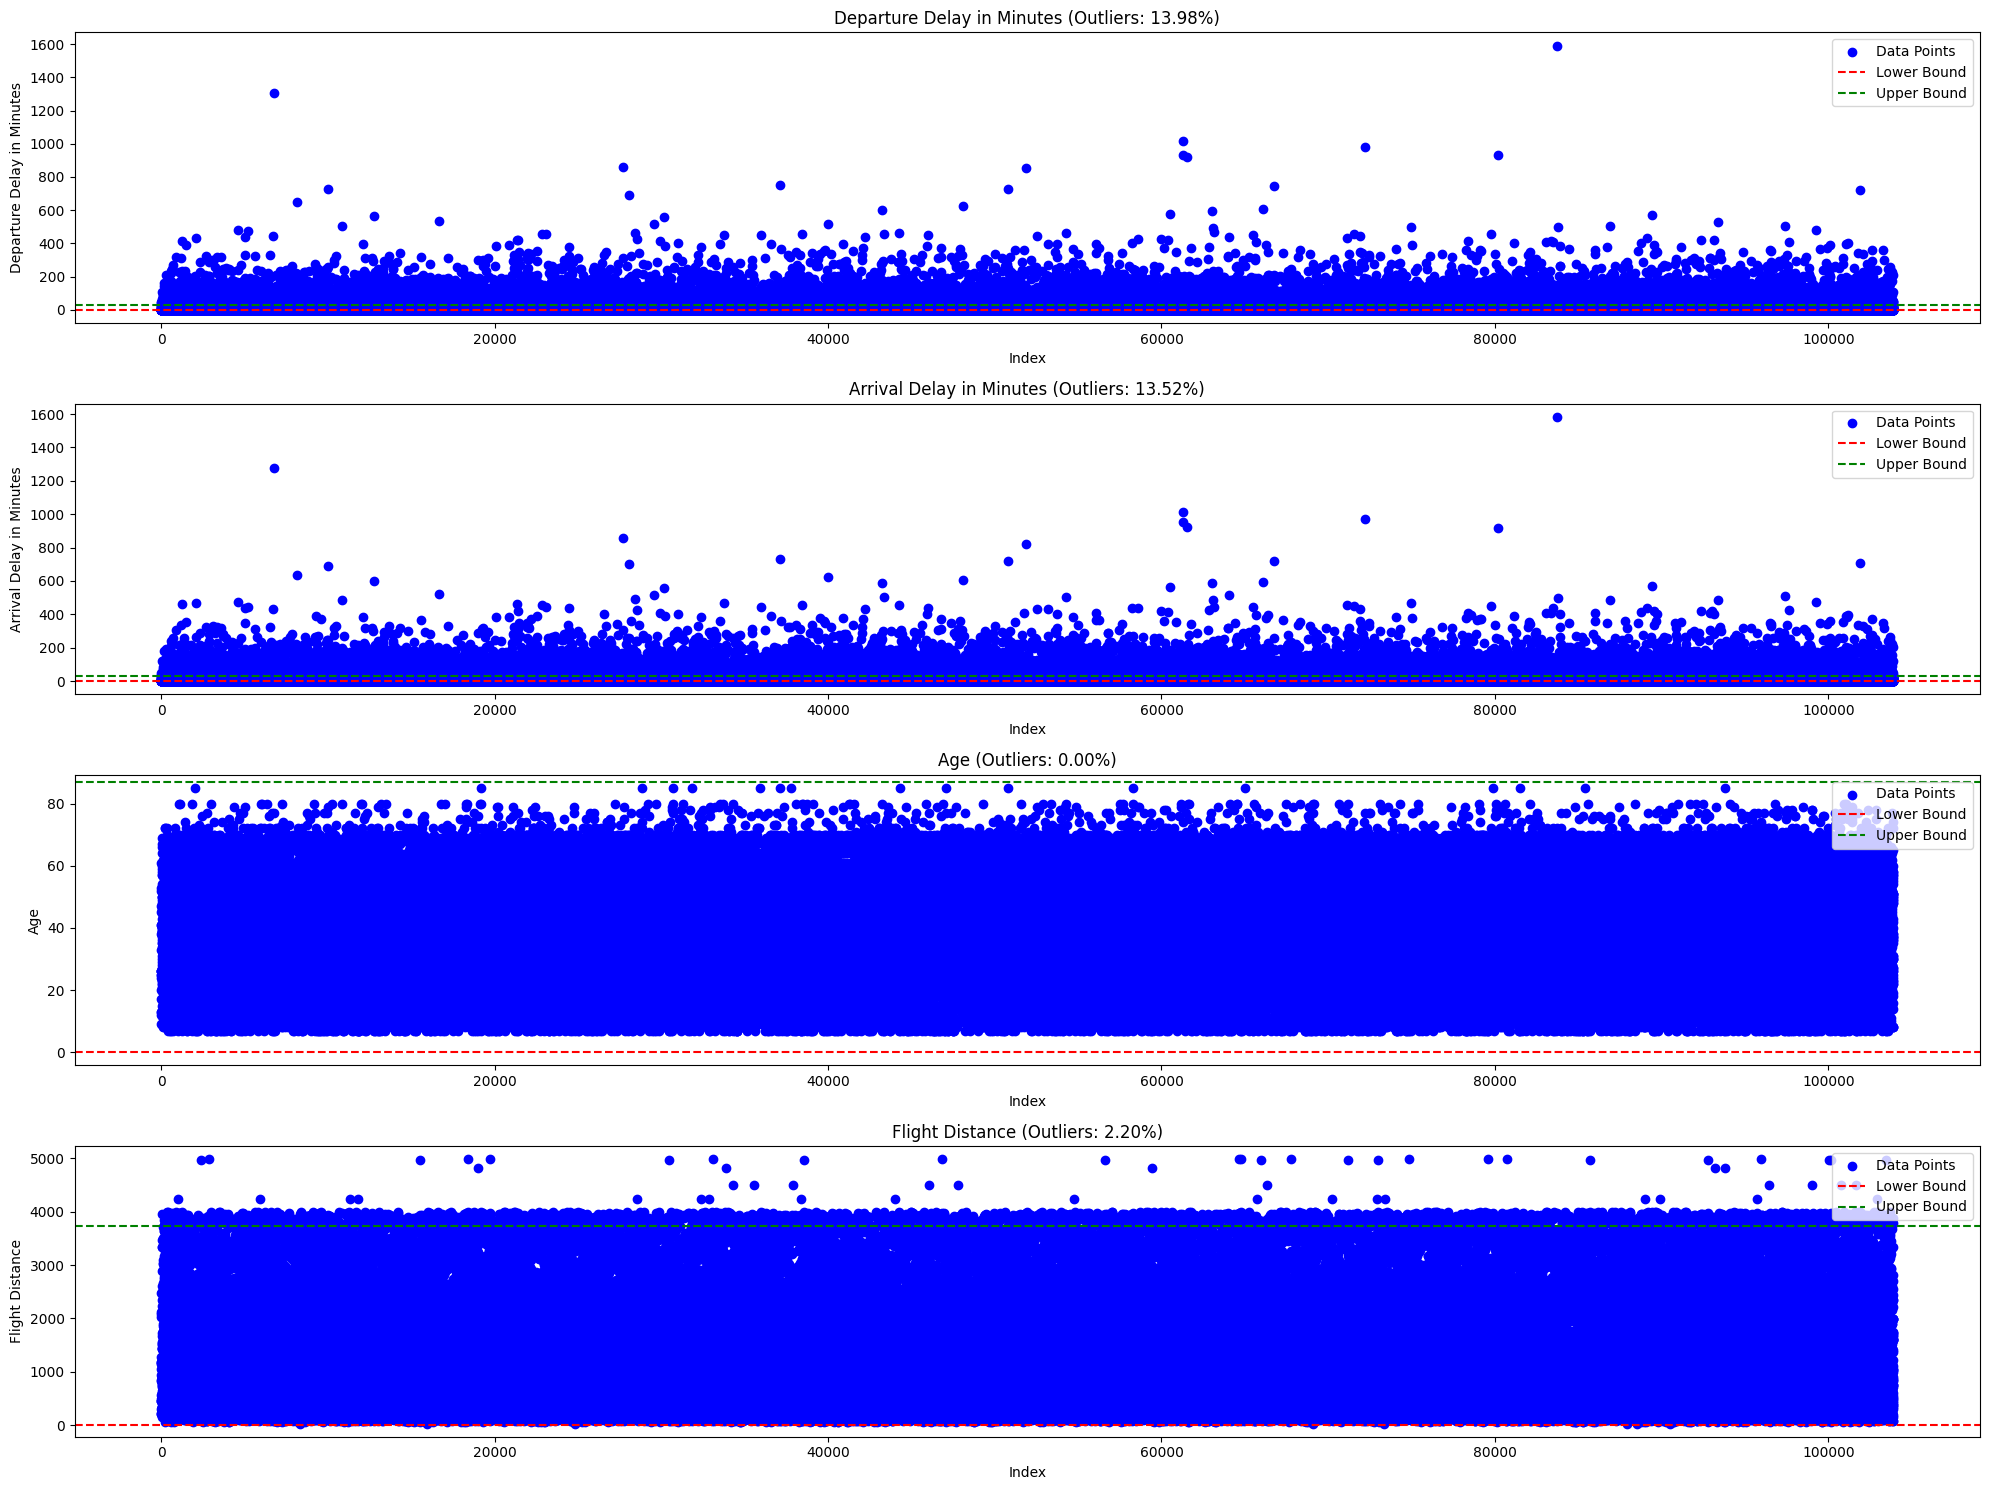

In [20]:
con_columns = ["Departure Delay in Minutes", "Arrival Delay in Minutes", "Age", "Flight Distance"]

fig, ax = plt.subplots(len(con_columns), 1, figsize=(20, 15))

for i, column in enumerate(con_columns):
    lower_bound, upper_bound = calculate_iqr_bounds(data_final_it[column])

    outlier_mask = (data_final_it[column] < lower_bound) | (data_final_it[column] > upper_bound)
    n_outliers = outlier_mask.sum()
    total = len(data_final_it[column])
    percent_outliers = (n_outliers / total) * 100

    ax[i].scatter(data_final_it.index, data_final_it[column], color='blue', label='Data Points')

    ax[i].axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound')
    ax[i].axhline(y=upper_bound, color='green', linestyle='--', label='Upper Bound')

    ax[i].set_title(f"{column} (Outliers: {percent_outliers:.2f}%)")
    ax[i].set_xlabel('Index')
    ax[i].set_ylabel(column)

    ax[i].legend()

plt.tight_layout()
plt.show()

### **Data Setelah Transformasi**

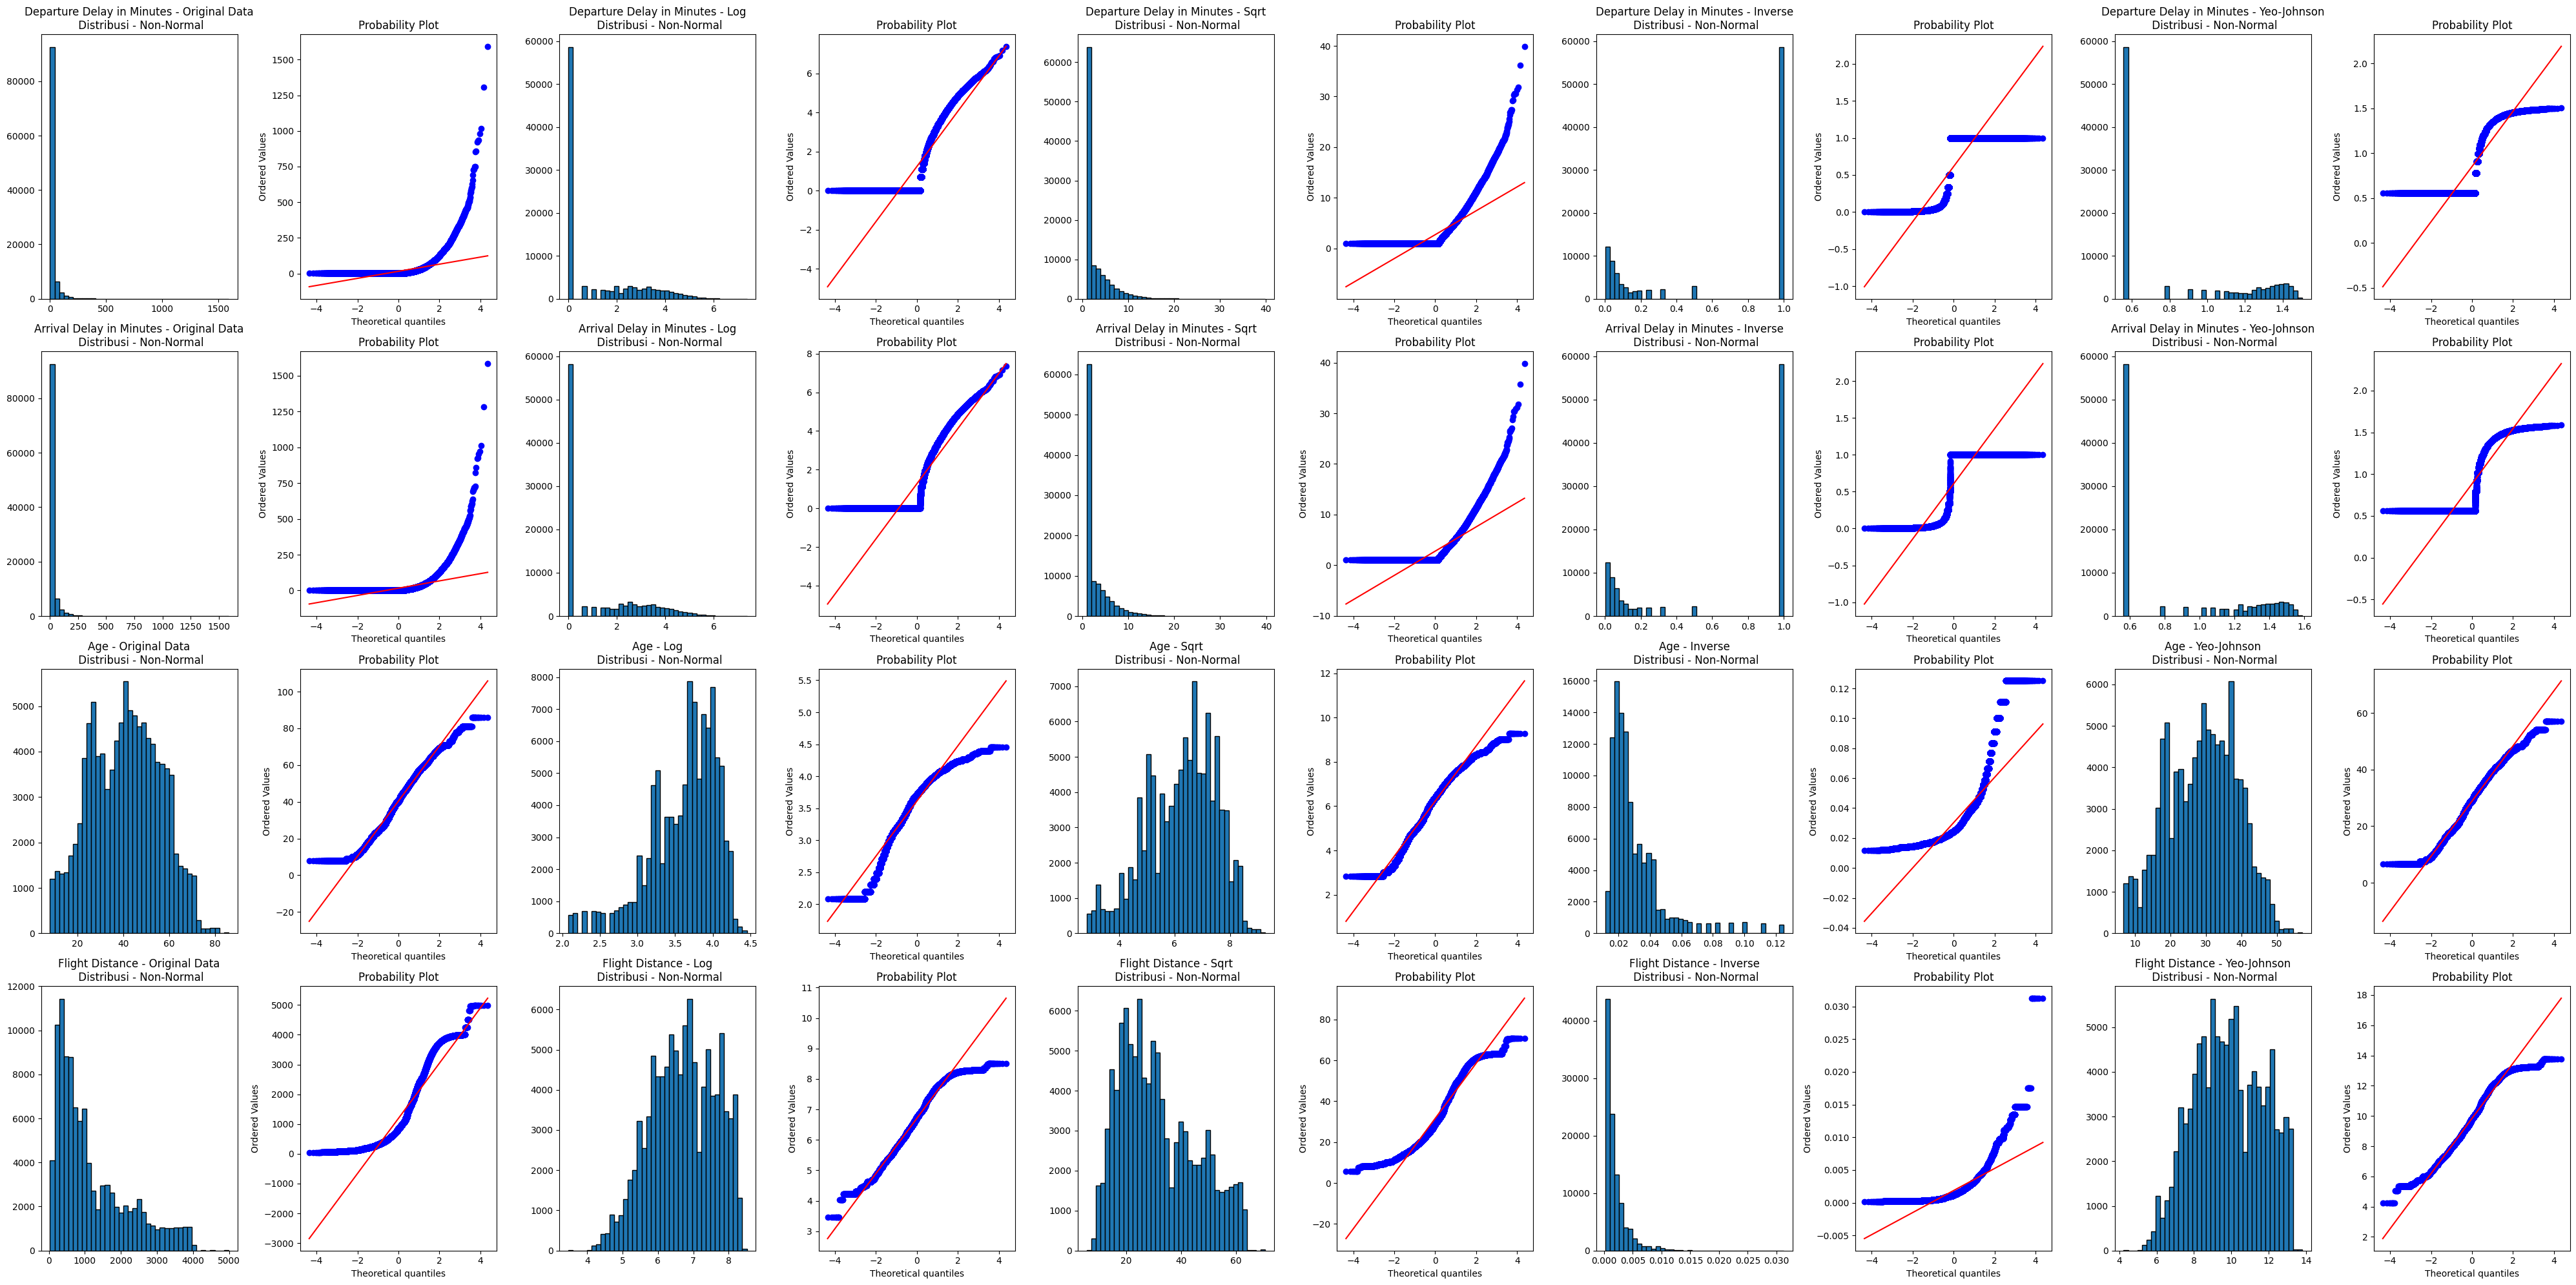

In [21]:
transformed_columns = ["Departure Delay in Minutes", "Arrival Delay in Minutes", "Age", "Flight Distance"]

fig, ax = plt.subplots(len(transformed_columns), 10, figsize=(40, 20))

for i, column in enumerate(transformed_columns):
    x = data_final_it[column] + 1
    transform_methods = [x, np.log(x), np.sqrt(x), 1/x, stats.yeojohnson(x)[0]]
    method_names = ["Original Data", "Log", "Sqrt", "Inverse", "Yeo-Johnson"]

    for j, transform in enumerate(transform_methods):
        result = stats.anderson(transform, dist='norm')
        distribusi = 'Normal' if result.statistic < result.critical_values[2] else 'Non-Normal'

        stats.probplot(transform, dist="norm", plot=ax[i, j * 2 + 1])
        ax[i, j * 2].hist(transform, bins=bins, edgecolor='black')
        ax[i, j * 2].set_title(f"{column} - {method_names[j]}\n Distribusi - {distribusi}")

plt.tight_layout()
plt.show()

Cara saya untuk menentukan metode transformasi yang akan saya pakai adalah dengan melihat apakah titik biru mengikuti atau mendekati garis diagonal merah.

In [22]:
df_log = data_final_it.copy(deep=True)
df_log['Departure Delay in Minutes'] = np.log(data_final_it['Departure Delay in Minutes'] + 1)
df_log['Arrival Delay in Minutes'] = np.log(data_final_it['Arrival Delay in Minutes'] + 1)
df_log['Flight Distance'] = np.log(data_final_it['Flight Distance'] + 1)

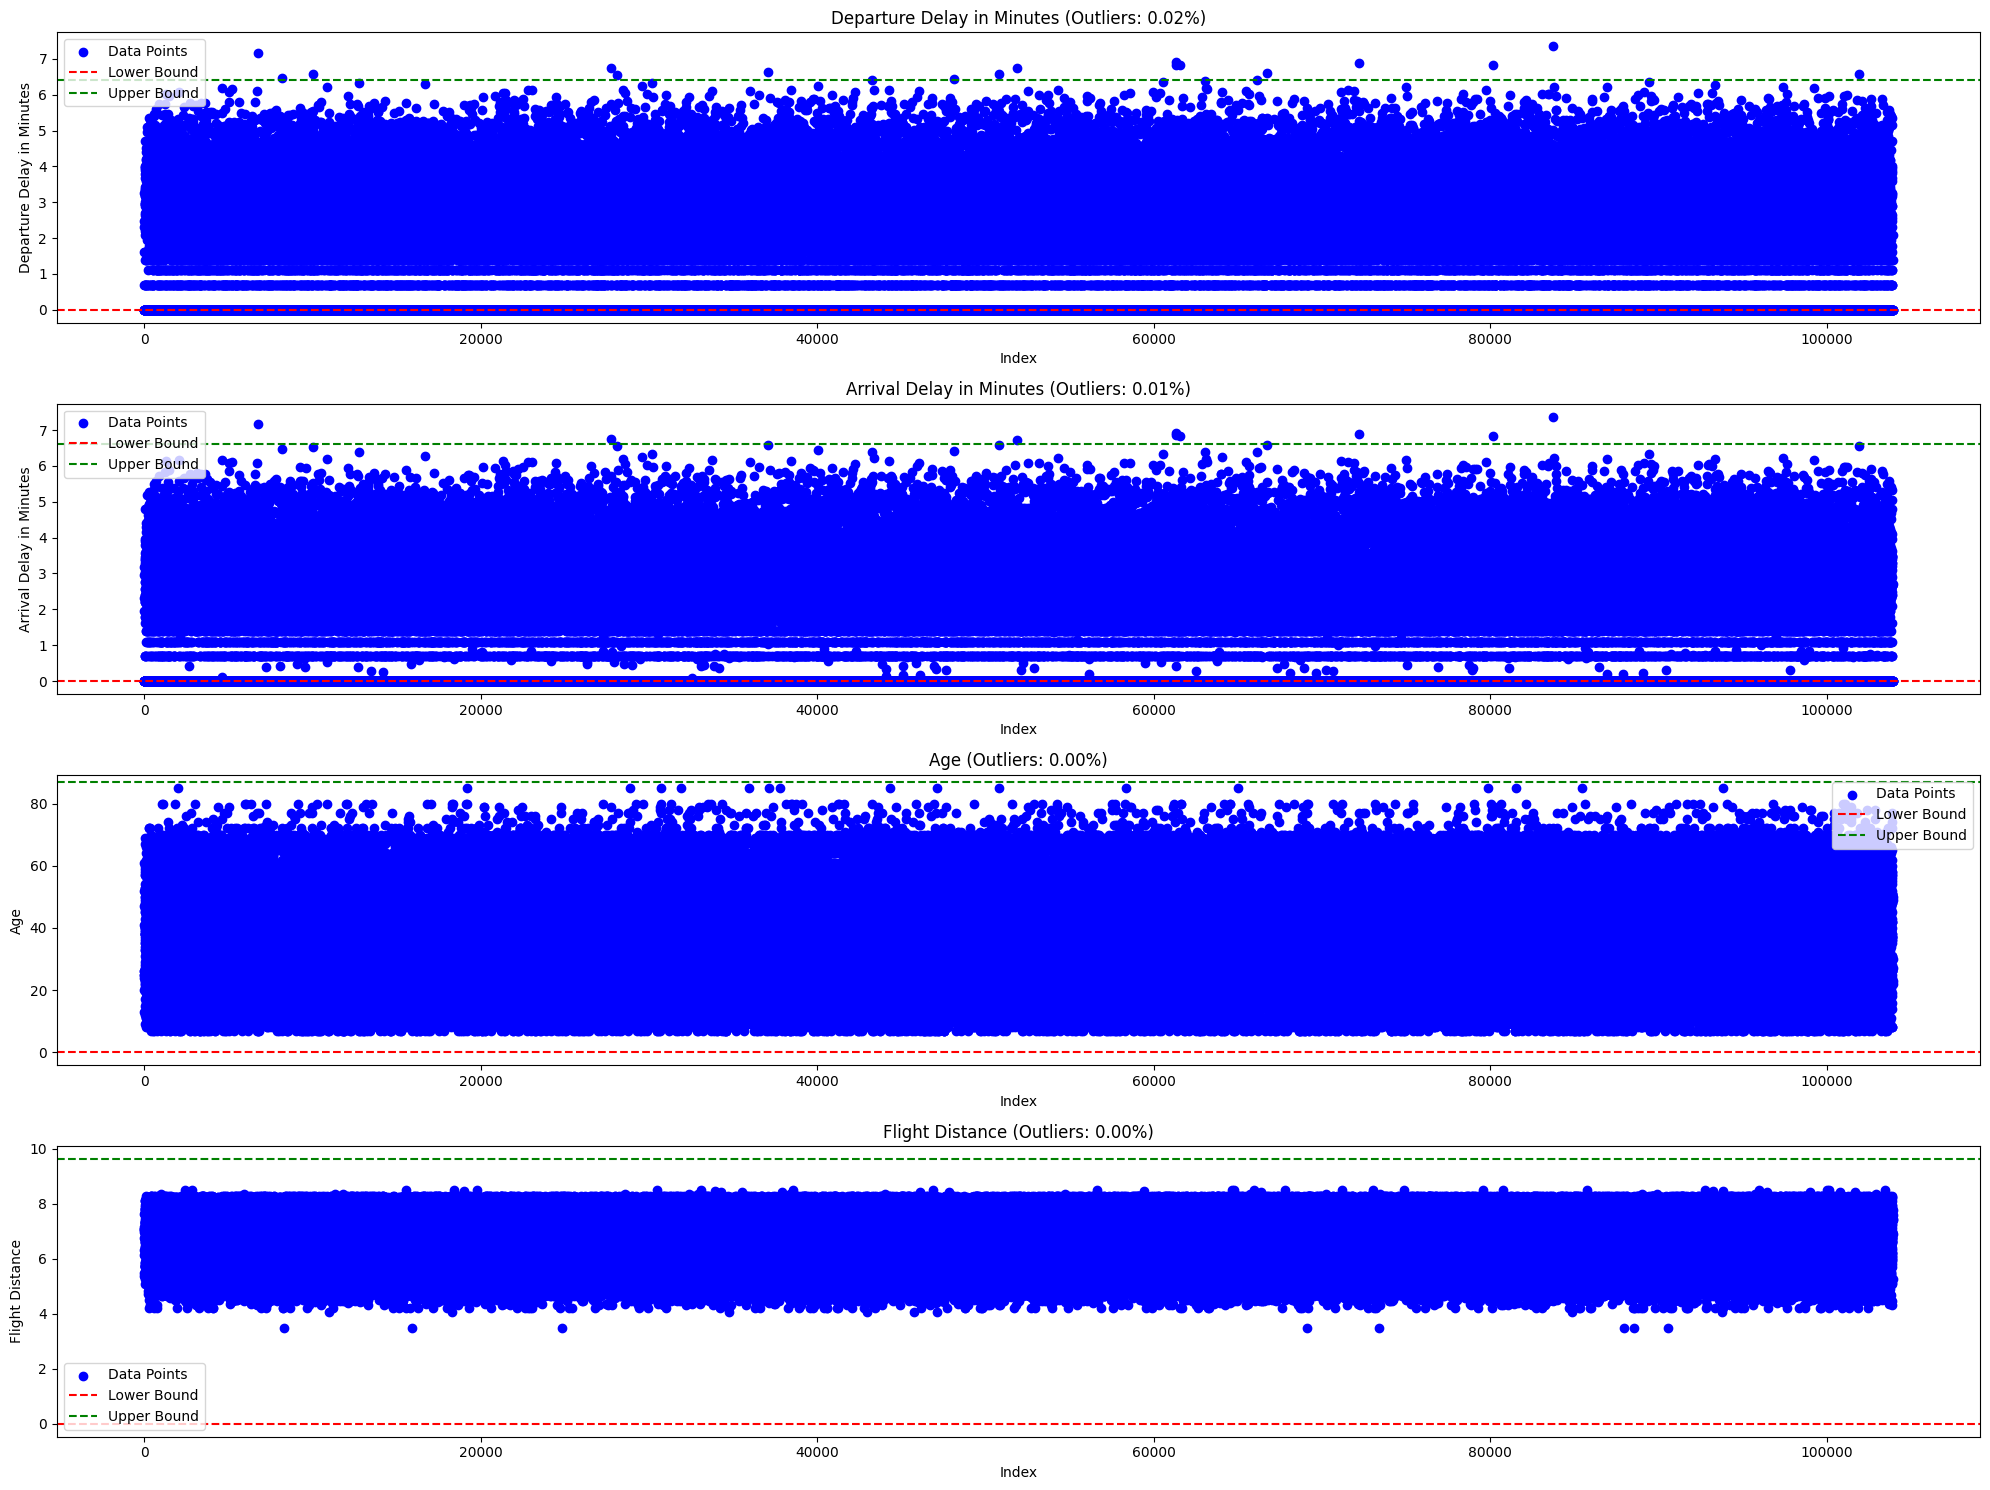

In [23]:
con_columns = ["Departure Delay in Minutes", "Arrival Delay in Minutes", "Age", "Flight Distance"]

fig, ax = plt.subplots(len(con_columns), 1, figsize=(20, 15))

for i, column in enumerate(con_columns):
    lower_bound, upper_bound = calculate_iqr_bounds(df_log[column])

    outlier_mask = (df_log[column] < lower_bound) | (df_log[column] > upper_bound)
    n_outliers = outlier_mask.sum()
    total = len(df_log[column])
    percent_outliers = (n_outliers / total) * 100

    ax[i].scatter(df_log.index, df_log[column], color='blue', label='Data Points')

    ax[i].axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound')
    ax[i].axhline(y=upper_bound, color='green', linestyle='--', label='Upper Bound')

    ax[i].set_title(f"{column} (Outliers: {percent_outliers:.2f}%)")
    ax[i].set_xlabel('Index')
    ax[i].set_ylabel(column)

    ax[i].legend()

plt.tight_layout()
plt.show()

## **Visualisasi Outliers Setelah Transformasi Dengan LOF**

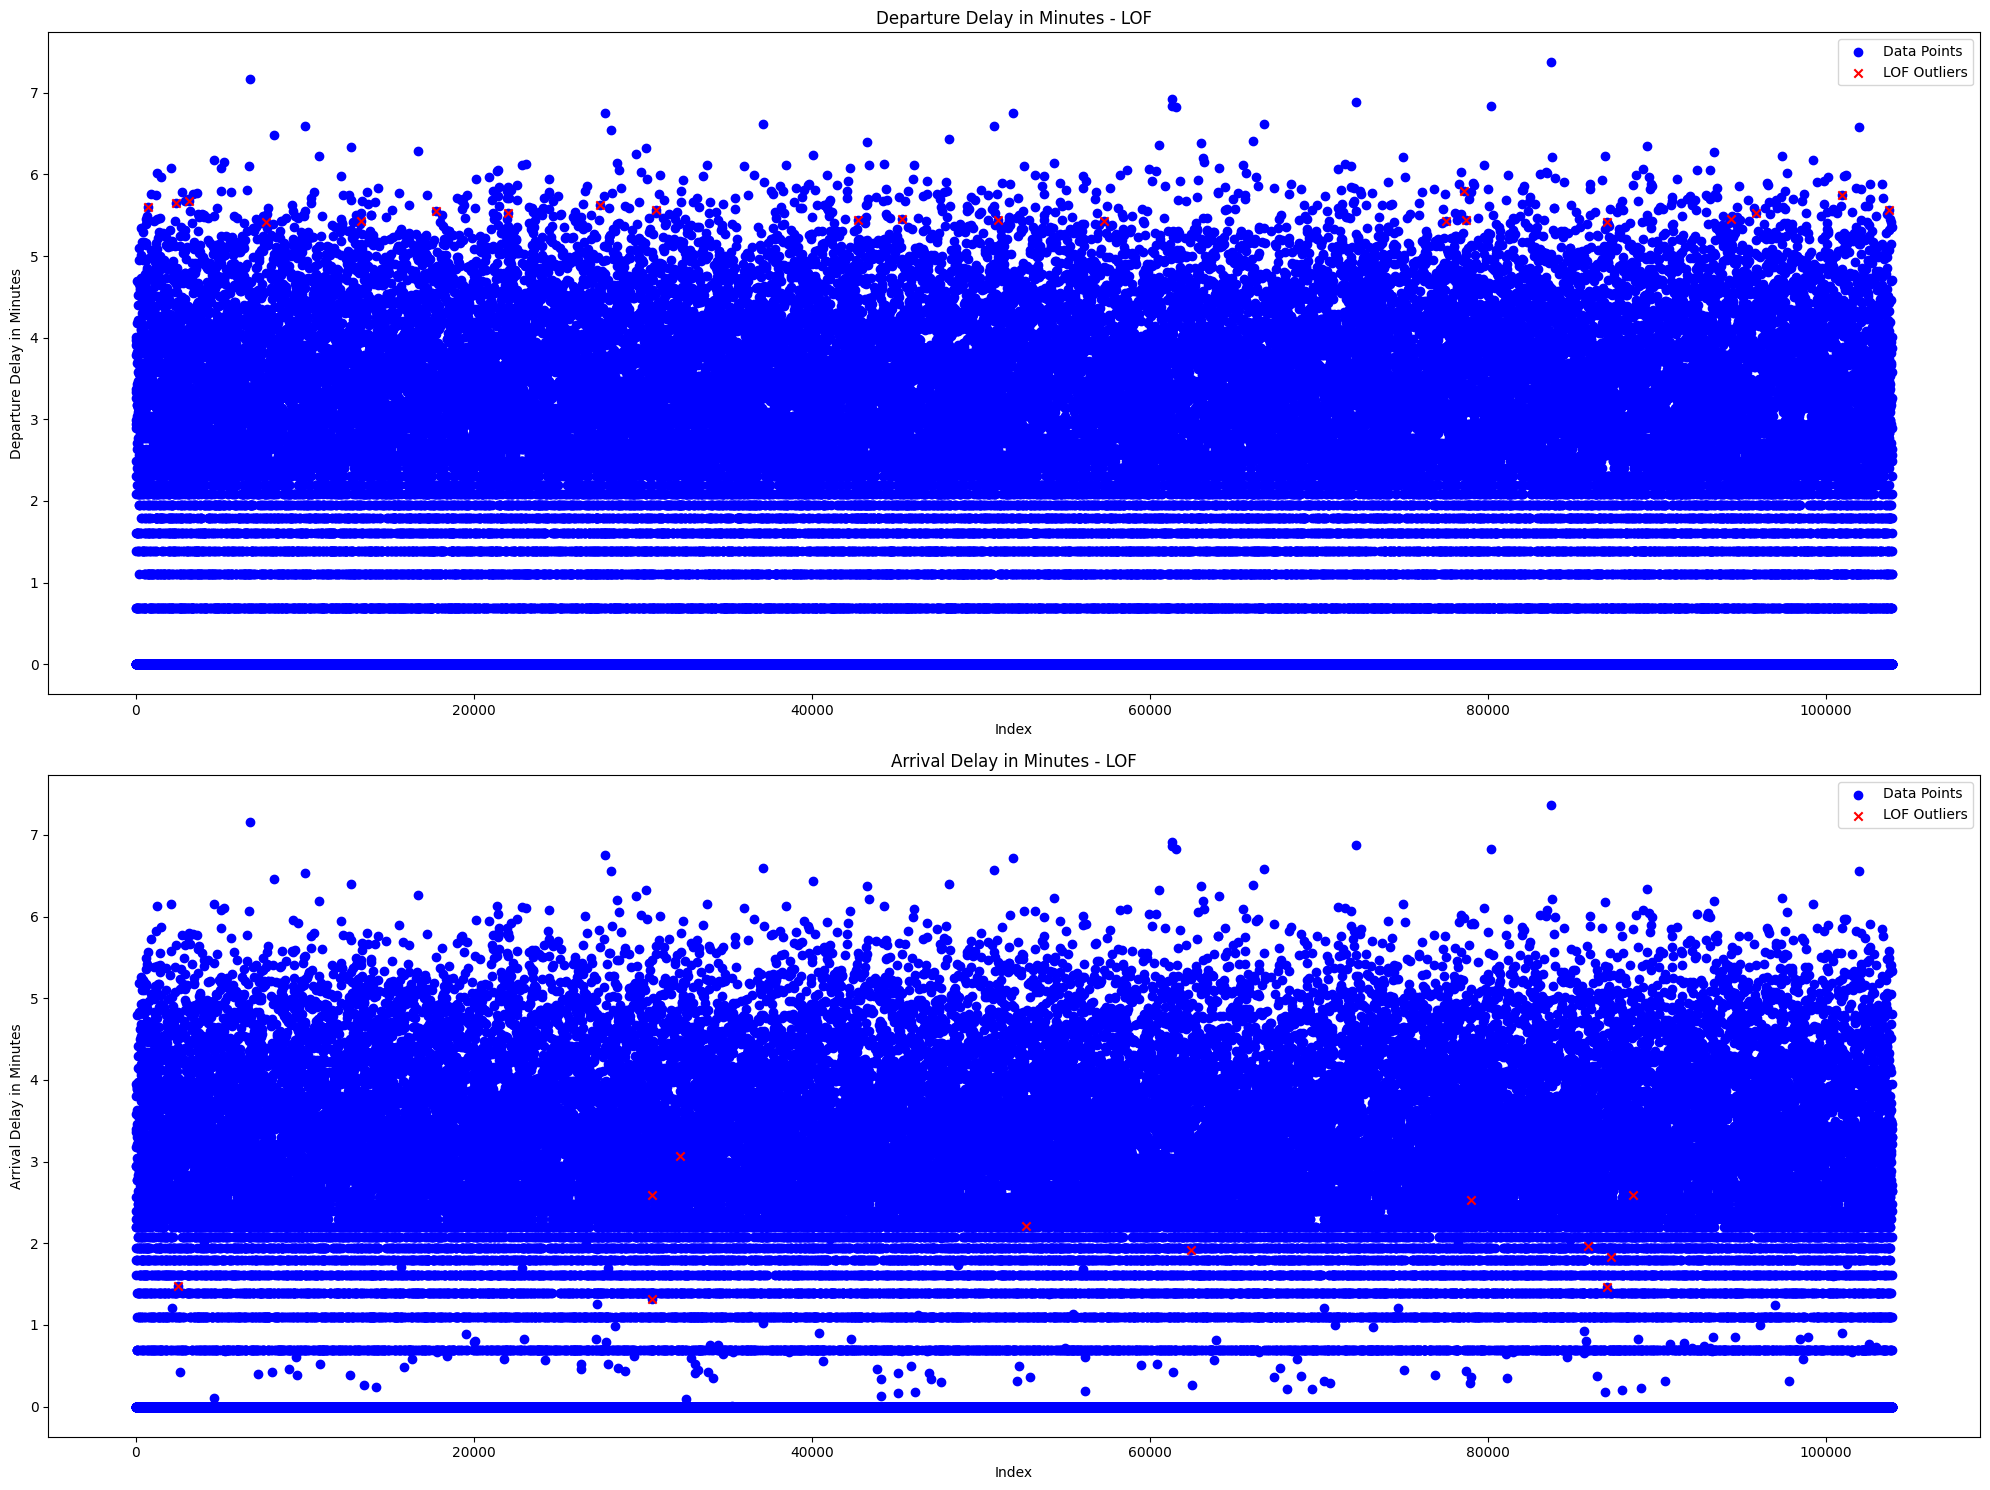

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))

for i, column in enumerate(con_columns):

    if i > 1:
        break
    percent = [0.0002, 0.0001]

    lof = LocalOutlierFactor(n_neighbors=4, contamination=percent[i])
    lof_preds = lof.fit_predict(pd.DataFrame(df_log[column]))
    lof_outliers = lof_preds == -1

    ax[i].scatter(df_log.index, df_log[column], color='blue', label='Data Points')
    ax[i].scatter(df_log[lof_outliers].index, df_log[column][lof_outliers],
                  color='red', label='LOF Outliers', marker='x')

    ax[i].set_title(f"{column} - LOF")
    ax[i].set_xlabel('Index')
    ax[i].set_ylabel(column)
    ax[i].legend()

plt.tight_layout()
plt.show()


## **Visualisasi Outliers Setelah Transformasi Dengan Isolation Forest**

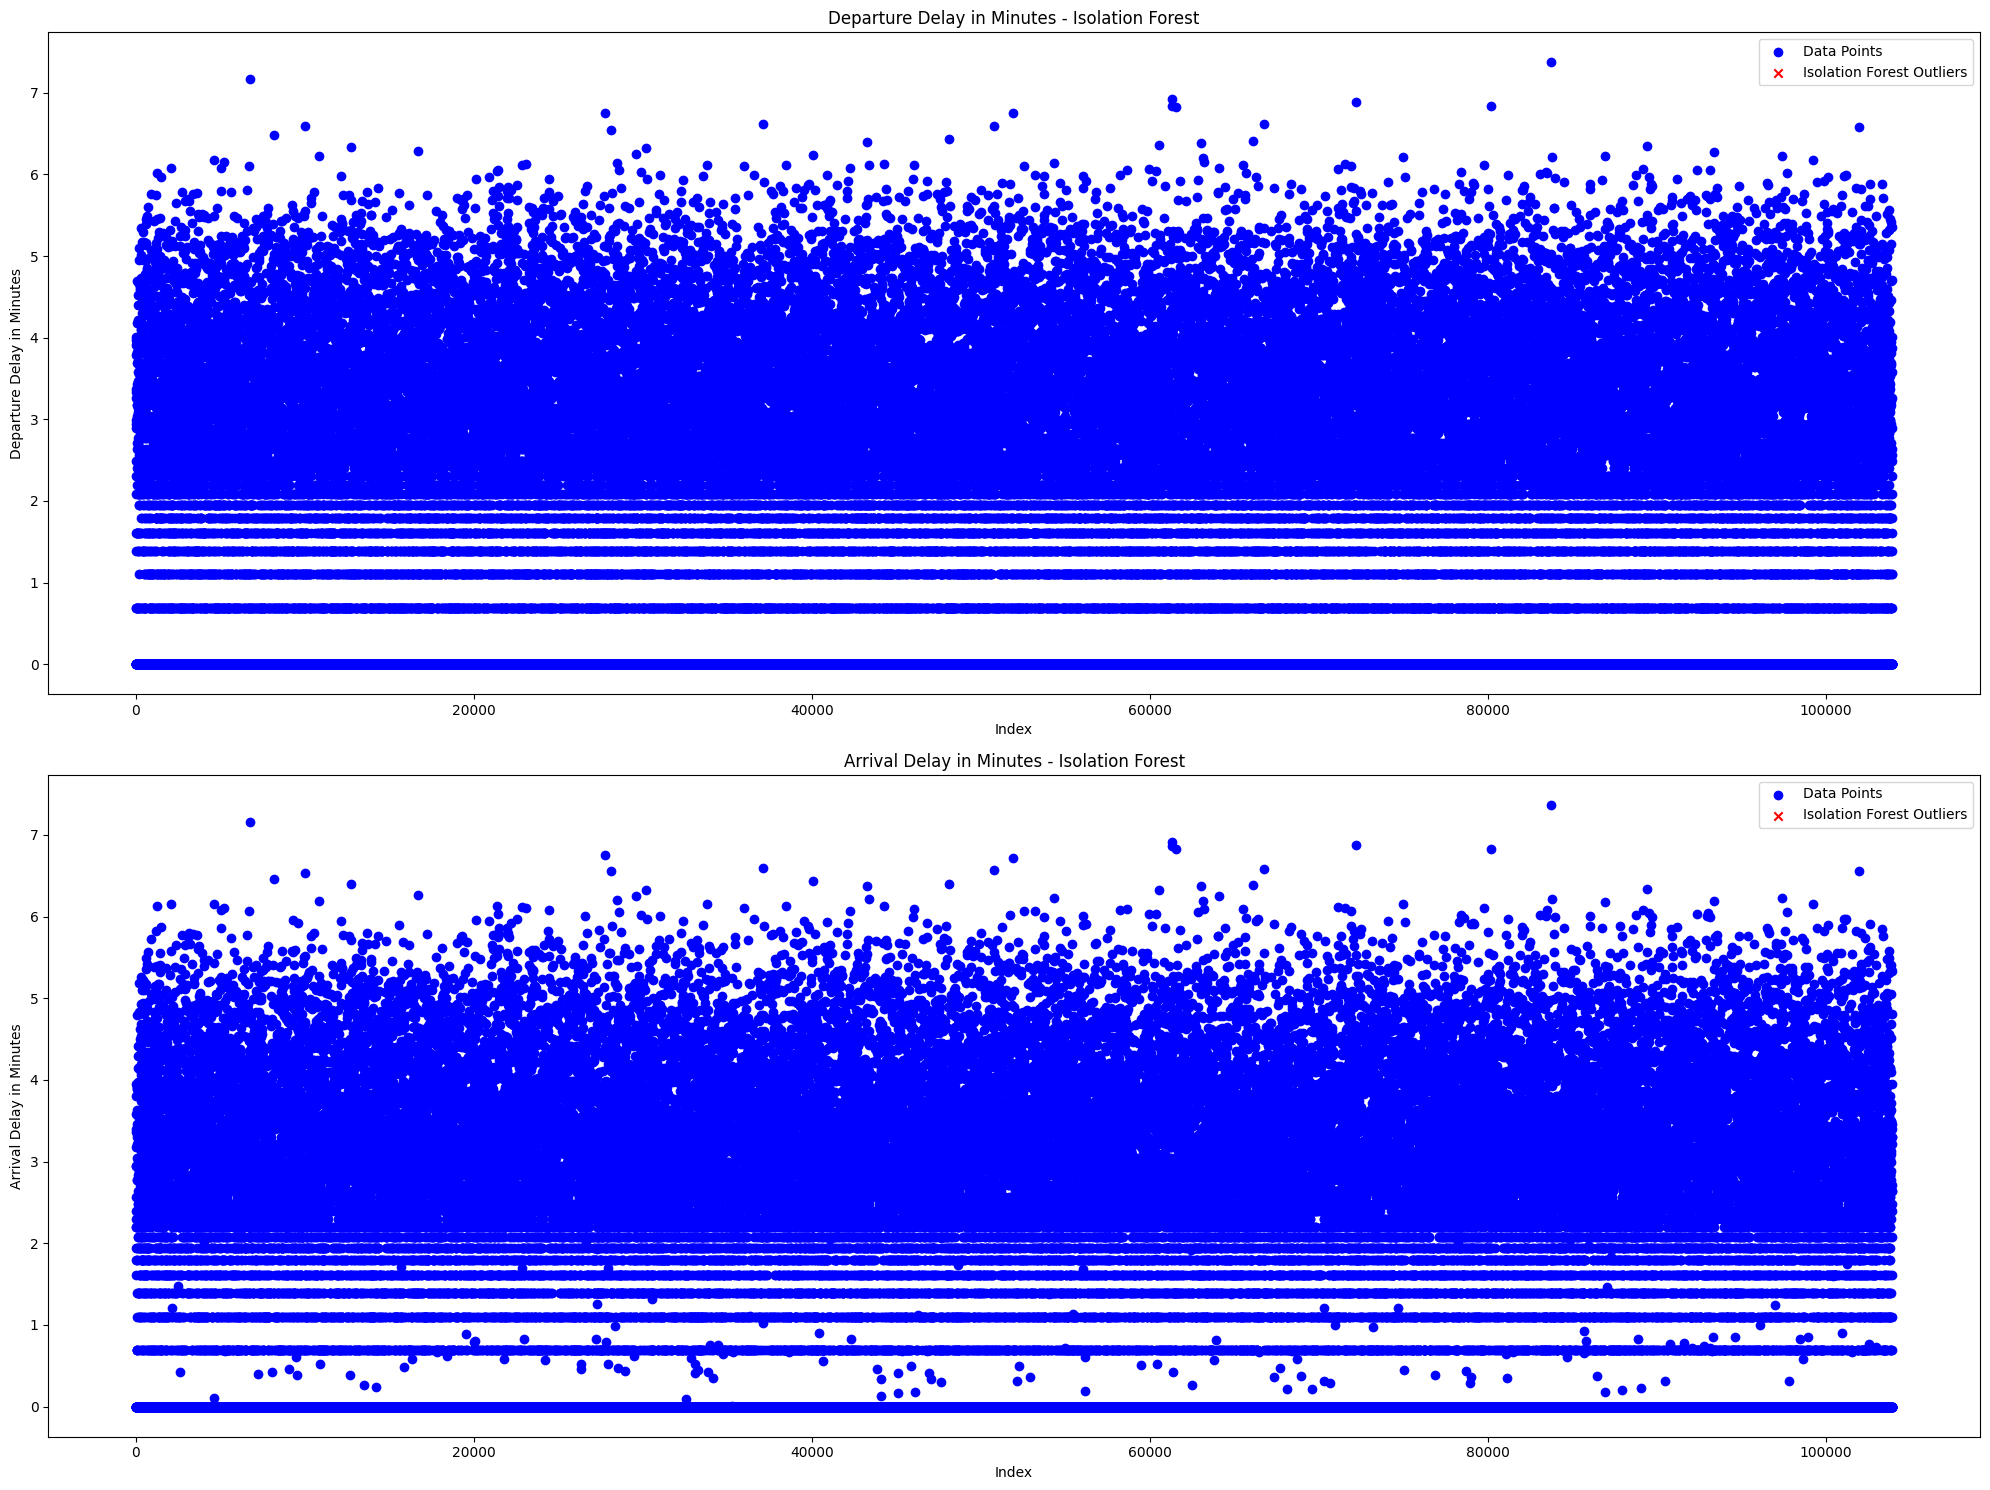

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))

for i, column in enumerate(con_columns):
    if i > 1:
       break

    percent = [0.0002, 0.0001]

    iso_forest = IsolationForest(contamination=percent[i], random_state=42)

    iso_preds = iso_forest.fit_predict(pd.DataFrame(df_log[column]))

    iso_outliers = iso_preds == -1

    ax[i].scatter(df_log.index, df_log[column], color='blue', label='Data Points')
    ax[i].scatter(df_log[iso_outliers].index, df_log[column][iso_outliers],
                  color='red', label='Isolation Forest Outliers', marker='x')

    ax[i].set_title(f"{column} - Isolation Forest")
    ax[i].set_xlabel('Index')
    ax[i].set_ylabel(column)
    ax[i].legend()

plt.tight_layout()
plt.show()


Setelah melihat jumlah outliers dan hasil setelah transformasi, saya putuskan untuk tidak memproses data outliers dan fokus pada model-model yang lebih tahan terhadap outliers seperti K-Medoids, DBSCAN, HDBSCAN, dan Centroid Linkage

# **6. Factor Analysis**

In [26]:
chi_square_statistic, p_value = calculate_bartlett_sphericity(data_final_it)

print("Chi-Square Statistic: ", chi_square_statistic)
print("P-value: ", p_value)

Chi-Square Statistic:  1043299.346251159
P-value:  0.0


In [27]:
kmo_all, kmo_model = calculate_kmo(data_final_it)

print("KMO for All Variables:", kmo_all)
print("KMO for Model:", kmo_model)

KMO for All Variables: [0.3921397  0.46382159 0.67248381 0.54372259 0.68449861 0.77549453
 0.72425035 0.71514393 0.6938894  0.70022774 0.84022158 0.76548336
 0.85979277 0.76128393 0.8399835  0.89621258 0.81595598 0.72457924
 0.78180868 0.81028801 0.50215712 0.50245333]
KMO for Model: 0.7188842184930119


In [28]:
final_data = data_final_it.iloc[::, [i > 0.5 for i in kmo_all]] # Hanya mengambil fitur yang memiliki nilai KMO lebih dari 0.5

## **Menentukan Jumlah Faktor dengan PCA**

In [29]:
scaler = RobustScaler()
data_scaled = scaler.fit_transform(final_data)

In [30]:
pca = PCA()
pca.fit(data_scaled)

PCA()

In [31]:
eigen_values = pca.explained_variance_
rasio_varians = pca.explained_variance_ratio_
rasio_cum = rasio_varians.cumsum()

In [32]:
pca_results = pd.DataFrame({
    'Eigen Value': eigen_values,
    'Rasio Variance': rasio_varians,
    'cumulative percentage of variance': rasio_cum
})
pca_results.index = ['comp ' + str(i+1) for i in pca_results.index]

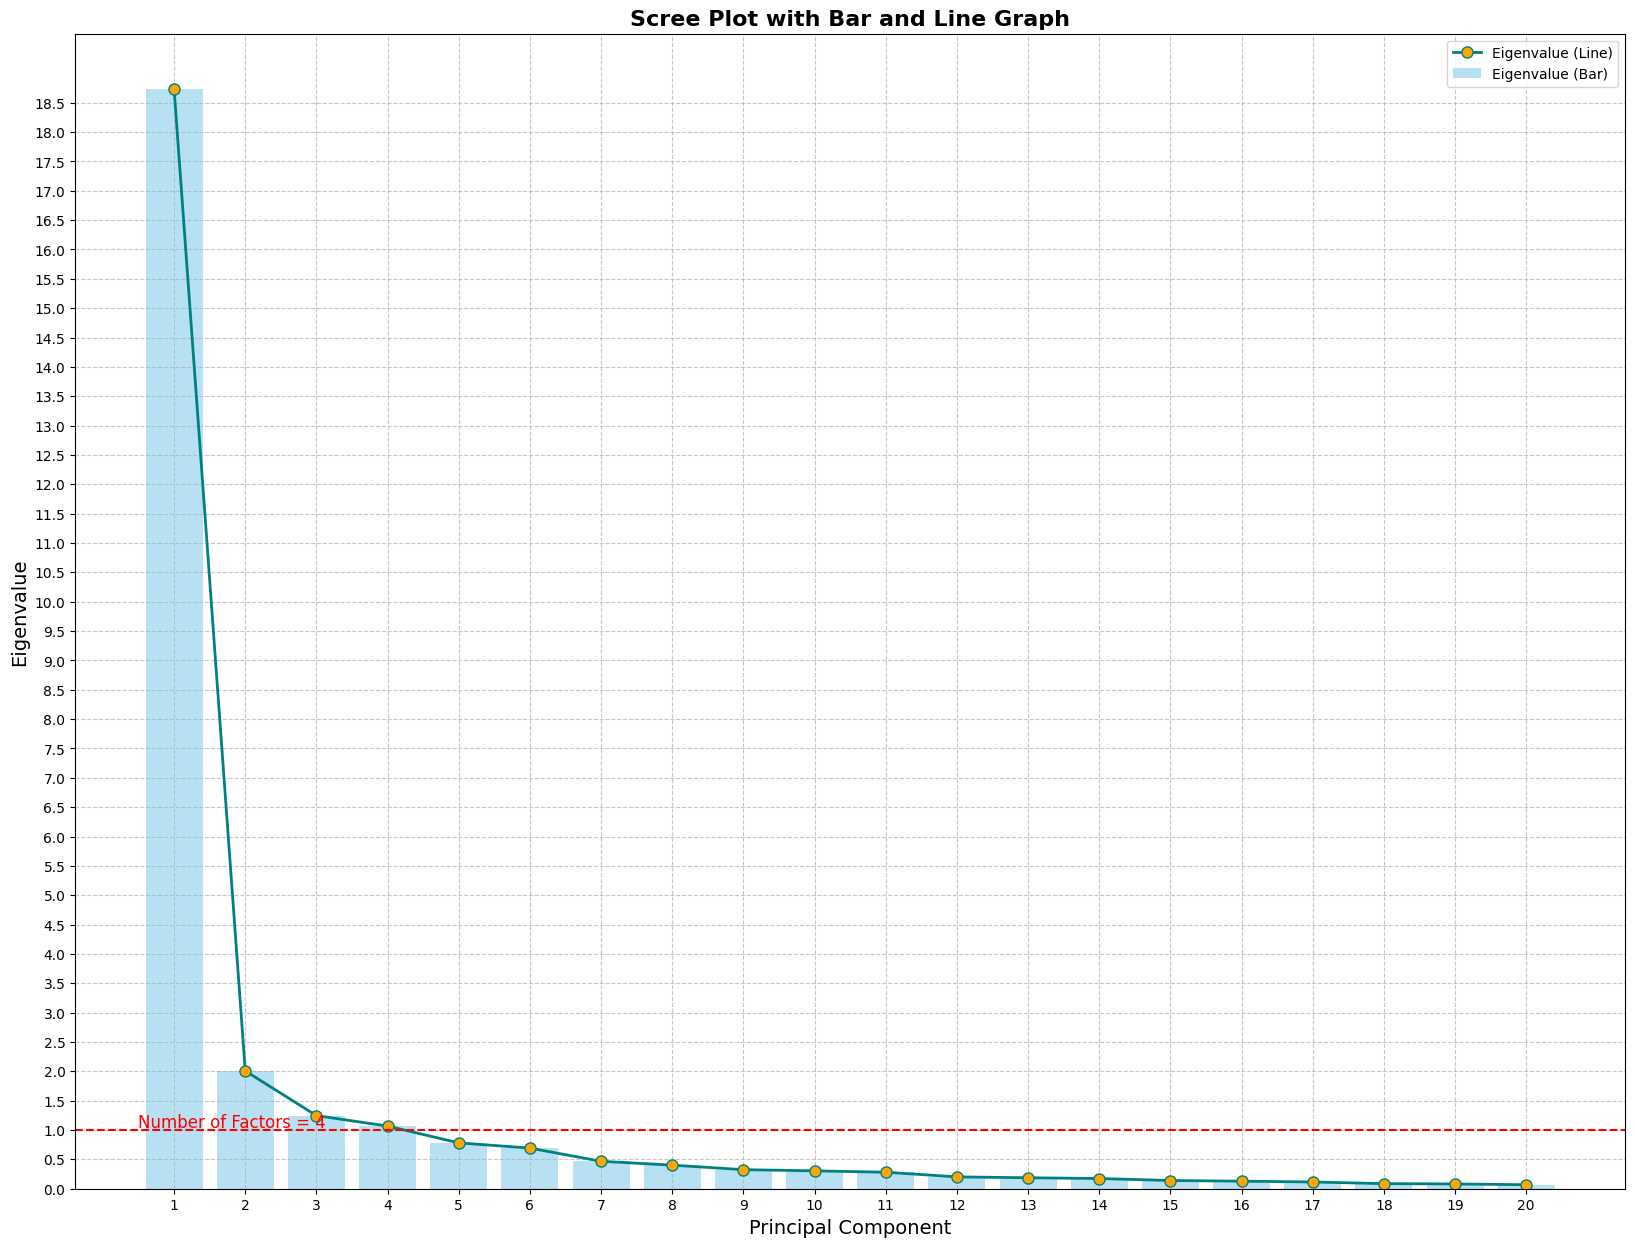

In [33]:
plt.figure(figsize=(20, 15))
plt.bar(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, alpha=0.6, color='skyblue', label='Eigenvalue (Bar)')
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'o-', linewidth=2, color='teal', markerfacecolor='orange', markersize=8, label='Eigenvalue (Line)')
plt.title('Scree Plot with Bar and Line Graph', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Eigenvalue', fontsize=14)
plt.axhline(y=1, color='red', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(pca.explained_variance_) + 1))
plt.yticks(np.arange(0, max(pca.explained_variance_), step=0.5))
plt.legend()

n_factors = np.sum(pca.explained_variance_ >= 1)
plt.text(0.5, 1.05, f'Number of Factors = {n_factors}', color = 'red', fontsize=12)

plt.show()

In [34]:
fa = FactorAnalyzer(n_factors=4, rotation='varimax')
fa.fit(data_scaled)

FactorAnalyzer(n_factors=4, rotation='varimax', rotation_kwargs={})

In [35]:
result = pd.DataFrame(fa.loadings_, index=final_data.columns, columns=[f'Factor {i+1}' for i in range(4)])
result

,Factor 1,Factor 2,Factor 3,Factor 4
Age,0.145372,0.000839,0.043368,-0.006511
Type of Travel,0.204580,0.113232,0.056555,0.019174
Class,0.264207,0.266052,0.052757,0.007471
Flight Distance,0.191166,0.149303,0.039185,0.012695
Inflight wifi service,0.207031,0.124886,0.736727,-0.010790
Departure/Arrival time convenient,-0.029008,0.042897,0.493292,-0.003425
Ease of Online booking,0.094680,0.035245,0.936469,0.000240
Gate location,-0.010093,-0.030068,0.503685,0.006048
Food and drink,0.721556,-0.005991,-0.043571,-0.024509
Online boarding,0.464342,0.134132,0.344712,-0.008164


### **Faktor 1**
- Food and Drink - 0.721556
- Seat Comfort - 0.807763
- Inflight entertainment - 0.727824
- Cleanliness - 0.825633

### **Faktor 2**
- On-board service - 0.701839
- Baggage handling - 0.755755
- Inflight service - 0.785849

### **Faktor 3**
- Inflight wifi service - 0.736727
- Ease of Online booking - 0.936469
- Gate location - 0.503685

### **Faktor 4**
- Departure Delay in Minutes - 0.982140
- Arrival Delay in Minutes - 0.982184


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [ ]:
def compare_model(data):

    # HDBSCAN



## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [ ]:
#Type your code here

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [ ]:
#Type your code here

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

In [ ]:
#Type your code here

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

**Tutorial: Melakukan Inverse Transform pada Data Target Setelah Clustering**

Setelah melakukan clustering dengan model **KMeans**, kita perlu mengembalikan data yang telah diubah (normalisasi, standarisasi, atau label encoding) ke bentuk aslinya. Berikut adalah langkah-langkahnya.

---

**1. Tambahkan Hasil Label Cluster ke DataFrame**
Setelah mendapatkan hasil clustering, kita tambahkan label cluster ke dalam DataFrame yang telah dinormalisasi.

```python
df_normalized['Cluster'] = model_kmeans.labels_
```

Lakukan Inverse Transform pada feature yang sudah dilakukan Labelisasi dan Standararisasi. Berikut code untuk melakukannya:
label_encoder.inverse_transform(X_Selected[['Fitur']])

Lalu masukkan ke dalam kolom dataset asli atau membuat dataframe baru
```python
df_normalized['Fitur'] = label_encoder.inverse_transform(df_normalized[['Fitur']])
```
Masukkan Data yang Sudah Di-Inverse ke dalam Dataset Asli atau Buat DataFrame Baru
```python
df_original['Fitur'] = df_normalized['Fitur']
```

In [ ]:
# Type your code here


### Inverse Data Jika Melakukan Normalisasi/Standardisasi

Inverse Transform untuk Data yang Distandarisasi
Jika data numerik telah dinormalisasi menggunakan StandardScaler atau MinMaxScaler, kita bisa mengembalikannya ke skala asli:
```python
df_normalized[['Fitur_Numerik']] = scaler.inverse_transform(df_normalized[['Fitur_Numerik']])
```

In [ ]:
# Type your code here

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [ ]:
# Type your code here

Tulis hasil interpretasinya di sini.
1. Cluster 1:
2. Cluster 2:
3. Cluster 3:

# Contoh interpretasi [TEMPLATE]
# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

## Cluster 1:
- **Rata-rata Annual Income (k$):** 48,260  
- **Rata-rata Spending Score (1-100):** 56.48  
- **Analisis:** Cluster ini mencakup pelanggan dengan pendapatan tahunan menengah dan tingkat pengeluaran yang cukup tinggi. Pelanggan dalam cluster ini cenderung memiliki daya beli yang moderat dan mereka lebih cenderung untuk membelanjakan sebagian besar pendapatan mereka.

## Cluster 2:
- **Rata-rata Annual Income (k$):** 86,540  
- **Rata-rata Spending Score (1-100):** 82.13  
- **Analisis:** Cluster ini menunjukkan pelanggan dengan pendapatan tahunan tinggi dan pengeluaran yang sangat tinggi. Pelanggan di cluster ini merupakan kelompok premium dengan daya beli yang kuat dan cenderung mengeluarkan uang dalam jumlah besar untuk produk atau layanan.

## Cluster 3:
- **Rata-rata Annual Income (k$):** 87,000  
- **Rata-rata Spending Score (1-100):** 18.63  
- **Analisis:** Cluster ini terdiri dari pelanggan dengan pendapatan tahunan yang tinggi tetapi pengeluaran yang rendah. Mereka mungkin memiliki kapasitas finansial yang baik namun tidak terlalu aktif dalam berbelanja. Ini bisa menunjukkan bahwa mereka lebih selektif dalam pengeluaran mereka atau mungkin lebih cenderung untuk menyimpan uang.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.